# Apache Spark - Analyzing Food Insecurity in NYC using KeyFoods Price Catalogs

In this homework, we study the food insecurity problem by looking at the listed prices of various food items across neighborhoods in NYC. Our hypothesis is that *people living in areas with higher food insecurity problems would pay more for the same items compared to those in more secured areas*. For the scope of work, we will only assess food products from KeyFoods supermarkets, one of the top 4 Supermarket Leaders in Metro New York (according [Food Trade News 2021 report](https://www.foodtradenews.com/2021/06/29/food-trade-news-2021-market-study-issue/)). In particular, we will use the following datasets:

### **`keyfood_products.csv`**

This CSV file contains the price information about 2 million food items listed on KeyFoods stores in NYC.

|store|department|upc|product|size|price|
|--|--|--|--|--|--|
102|bakery|102-28556000000|Store Prepared - Challah Egg|1 EA|\$4.99 each|
102|bakery|102-28781600000|Store Prepared - fw Cheesecake Plain 7 Inch|1 EA|\$27.99 each|
|...|...|...|...|...|...|

The details of the columns are as follows:

|Column|Description|
|--|--|
|**store** | The unique id of each store |
|**department**| The department (or aisle) that the food item belongs to. Possible values are:<br />`'bakery'`,`'beverages'`,`'breakfast'`,`'deli'`,`'frozen'`,`'international'`,<br/>`'meatandseafood'`,`'pantry'`,`'produce'`,`'refrigerated'`, and `'snacks'`|
|**upc**|The unique id for each item in a food store. It is often in the format of `SID-XXXXXXXXXX`,<br/> where `SID` is a store id if it's specific to a store, `UPC` if it's a general product, or `'KEY'` <br/> if it's a KeyFoodsproduct. If an item doesn't have any UPC code, this field will be `N/A`.|
|**product**|This is the listed name of the product|
|**size**|The unit that the product is being sold in|
|**price**|The price text of the product as shown on their websites. This is not a number but have<br/>been verified to start with the price mark`$XX.XX`. Note that for items without price<br/>information, this field could be listed as `Price not Available`|



This is the *big data* part of the homework, where we need to use Apache Spark to process it. 



### **`keyfood_nyc_stores.json`**

This JSON file contains information for all KeyFoods stores in NYC. There are a lot of details about each store, however, for this homework, we are only interested in the following fields:

|Field|Description|
|--|--|
|**name** | This is the unique id of each store, which could be crosswalk with the **store** field above |
|**communityDistrict**|The community district code that the store belongs to. It's simply a larger geographical<br/> unit comparing to a zip code. More information can be found [here](https://communityprofiles.planning.nyc.gov/).|
|**foodInsecurity**|A food insecurity score computed for the community district that the stores belong to.<br/> This value has the range of 0 to 1 with 0 being without any food insecurity rish, and 1 <br/> has the most food insecure risk.|



### **`keyfood_sample_items.csv`**

This data contains the list of 22 food items that we would like to study initially to assess our hypothesis. For each item, we have the UPC code (which needs to be generalized across store) and the item name. Here is the list:

|UPC code|Item Name|
|--|--|
|SID-20308200000|Broccoli Crowns|
|KEY-000000004094|Fresh Produce - Carrot Bunch|
|KEY-000000004062|Fresh Produce - Cucumbers|
|SID-00000004072|Fresh Produce - Potatoes Russet|
|SID-00000004131|Fresh Produce - Apples Fuji Large|
|KEY-00000004013|Produce - Orange Navel 113|
|UPC-048500001004|Tropicana - Juice Orange Pure Prem Orig|
|UPC-017400108700|Carolina - Whole Grain Brown Rice|
|UPC-016000487697|General Mills - Cherrios Multi Grain Cereal|
|UPC-073296027686|Urban Meadow - 100 Whole Wheat Bread|
|UPC-048000013651|Chicken of the Sea - Solid Wht Albacore Tuna in Oil|
|SID-20115200000|Beef - Beef Semi Bnls Chuck Stk|
|SID-28080600000|Perdue - Split Chicken Breast Fam Pack|
|UPC-073296057461|Urban Meadow - Plain Low Fat Yogurt|
|UPC-041757021443|Laughing Cow - White Cheddar Wedges|
|UPC-073296069280|Urban Meadow - Large White Eggs|
|UPC-088365000347|Cream O Land - Gallon 2% Milk|
|UPC-072940744016|Redpack - Tomato Crushed|
|UPC-051500255162|Jif - Creamy Peanut Butter|
|UPC-073296025903|Urban Meadow - Canola Oil|
|UPC-041331124461|Goya - Beans Cannelini Can|
|UPC-014500001894|Birds Eye - Spinach Leaf|

where `SID` should be replaced with the store id.


### Notes

* Our big data set (`keyfood_products.csv`) is assumed to be on HDFS, and must be accessed using Spark (either as RDD or DataFrame).

* You are not allowed to collect the raw data to the notebook and process them without using Spark. However, it is okay to collect intermediate data for processing. Just try to collect as little as possible.

## Environment Setup

Since there's a number of issues with `gdown` recently, we're switching to use `curl` to download the data files.

In [1]:
!curl -L "https://drive.google.com/uc?id=1O1U_t-cpmValVK2mjdTzcFxIbGw05vOw&confirm=t" > keyfood_sample_items.csv
!curl -L "https://drive.google.com/uc?id=1YUBKrtNV3QUz1RutMnMbJdQj7rv-Lkd5&confirm=t" > keyfood_nyc_stores.json
!curl -L "https://drive.google.com/uc?id=1f79oETtvN3NQLYPnVGhurE1UBDP4IQP-&confirm=t" > keyfood_products.csv
!pip install pyspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1116  100  1116    0     0   1760      0 --:--:-- --:--:-- --:--:--  1760
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  948k  100  948k    0     0  1010k      0 --:--:-- --:--:-- --:--:-- 1010k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180M  100  180M    0     0   136M      0  0:00:01  0:00:01 --:--:--  197M
     |████████████████████████████████| 281.4 MB 34 

In [2]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

## Task 1 - Visualizing Distributions of Listed Food Prices

In the first task, we would like to see how the listed prices for food items vary across stores. For each item in the sample list provided in `keyfood_sample_items.csv`, we can simply overlay a [strip plot](https://seaborn.pydata.org/generated/seaborn.stripplot.html) with a [violin plot](https://seaborn.pydata.org/generated/seaborn.violinplot.html). In addition, to better correlate the price distribution with the food insecurity risk, we will color the markers by the percentage of food insecurity (derived from the `foodInsecurity` field in `keyfood_nyc_stores.json`). An expected visualization is provided below:

In [ ]:
#@title

To produce the plot, we need to following data, where each row represents a listing of the sample food item from a store.

| Item Name	| Price ($) | % Food Insecurity |
|--|--|--|
|Urban Meadow - 100 Whole Wheat Bread | 2.29 | 11 |
|General Mills - Cherrios Multi Grain Cereal | 6.79 | 11 |
|Birds Eye - Spinach Leaf | 2.29 | 11 |
|Beef - Beef Semi Bnls Chuck Stk | 7.99 | 11 |
|Chicken of the Sea - Solid Wht Albacore Tuna in Oil | 2.49 | 11 |
| ... | ... | ... |

Your task is to compute the above table from the input data.

### INPUT
**You must read `keyfood_products.csv` into a Spark's DataFrame or Spark's RDD**, and process the data from there. You may assume the other two files (`keyfood_nyc_stores.json` and `keyfood_sample_items.csv`) are stored locally with your driver code.


### OUTPUT
Your output must be stored in another Spark's DataFrame or Spark's RDD, and being named as `outputTask1` at the end of the task. The column order must be the same as above (item name, price, and then % food insecurity). If your output is an RDD, each record should be a tuple of 3 elements. If your output is a Spark's DataFrame, it must have exactly 3 columns (you name them anything but they must in the same order).


### [TODO] A. Complete your code

Using either Spark's RDD or Spark's DataFrame transformations. The output must be placed in the `outputTask1` variable:

* Items must be filtered by UPC codes and names provided in the `keyfood_sample_items.csv`. UPC codes are considered equal if their numeric parts (the second portion after the `-`) are the same. For example, `SID-20308200000` is the same as `102-20308200000`, `KEY-20308200000`, etc.

* `Item Name` must be taken the sample items when there's a UPC code match (as defined above).

* `Price` should be extracted from the `price` column of `keyfood_products.csv`. The prefix `$` should be removed, and the output price should be converted to a float number (i.e. not a string).

*  `% Food Insecurity` is simply the percentage of the `foodInsecurity` score, i.e. by multiplying `foodInsecruity` by `100`.


In [3]:
import json
from pyspark.sql import functions as F
from pyspark.sql.functions import split
from pyspark.sql.functions import col

#get the 22 sample upc codes with their product name
keyFoodSample = spark.read.load('keyfood_sample_items.csv', format = 'csv', header = True, inferSchema = True) \
  .select(split(col('UPC code'),'-').getItem(1).alias('UPC'), 'Item Name')

#get the main data, add a column where price is converted to a float and a column where the upc numerical section is extracted
outputTask1 = spark.read.load('keyfood_products.csv', format = 'csv', header = True, inferSchema = True) \
  .select('store', 'upc','product', 'price') \
  .withColumn('PriceNum', (F.regexp_extract('price', '(\\d+.\\d{2})' , 0 )).cast('float')) \
  .withColumn('Extracted upc', split(col('upc'),"-").getItem(1))

#join the tables where there is a matching upc, take Item Name fromt the sample table
outputTask1 = outputTask1.join(keyFoodSample,((outputTask1['Extracted upc'] == keyFoodSample['UPC'])),'inner') \
                          .select('store', 'Item Name', 'PriceNum')

#create a table with all the stores and their food insecurity rating from the stores json file, multiply the rating by 100
insecurity = []
f = open('keyfood_nyc_stores.json')
keyFoodStores = json.load(f)
for i in keyFoodStores:
    insecurity.append((keyFoodStores[i]['name'], keyFoodStores[i]['foodInsecurity']*100))
f.close()
insecurityColumns = ['name','foodInsecurity']
insecurityDF = spark.createDataFrame(data=insecurity, schema = insecurityColumns)

#join the main table with the insecurity table where there is a matching store
outputTask1 = outputTask1.join(insecurityDF,outputTask1['store'] == insecurityDF['name'],'inner')

#selected desired columns in the correct order
outputTask1 = outputTask1.select('Item Name',
                                 outputTask1.PriceNum.alias('Price ($)'),
                                 outputTask1.foodInsecurity.alias('% Food Insecurity'))	

## DO NOT EDIT BELOW
outputTask1 = outputTask1.cache()
outputTask1.count()



3116

### B. Run to validate your output

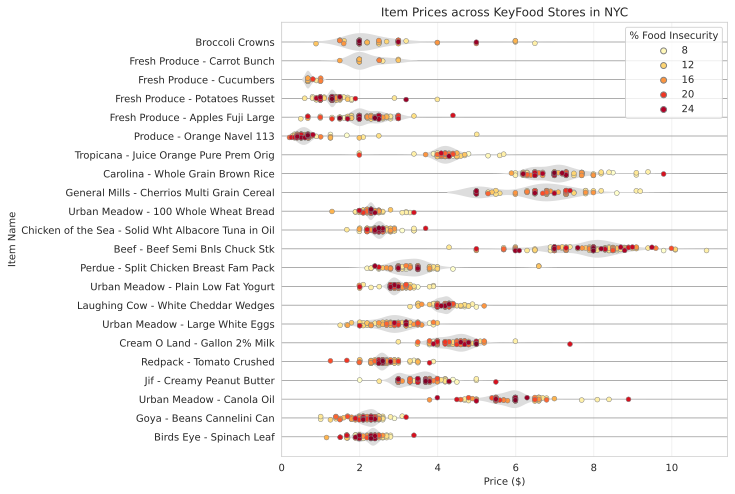

In [ ]:
#@title
def dfTask1(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>10000:
        raise Exception('`outputTask1` has too many rows')
    rows = map(lambda x: (x[0], x[1], int(x[2])), rdd.collect())
    return pd.DataFrame(data=rows, columns=['Item Name','Price ($)','% Food Insecurity'])

def plotTask1(data, figsize=(8,8)):
    itemNames = pd.read_csv('keyfood_sample_items.csv')['Item Name']
    itemKey = dict(map(reversed,enumerate(itemNames)))
    df = dfTask1(data).sort_values(
        by = ['Item Name', '% Food Insecurity'],
        key = lambda x: list(map(lambda y: itemKey.get(y,y), x)))
    plt.figure(figsize=figsize)
    ax = sns.violinplot(x="Price ($)", y="Item Name", data=df, linewidth=0,
                        color='#ddd', scale='width', width=0.95)
    idx = len(ax.collections)
    sns.scatterplot(x="Price ($)", y="Item Name", hue='% Food Insecurity', data=df,
                    s=24, linewidth=0.5, edgecolor='gray', palette='YlOrRd')
    for h in ax.legend_.legendHandles: 
        h.set_edgecolor('gray')
    pts = ax.collections[idx]
    pts.set_offsets(pts.get_offsets() + np.c_[np.zeros(len(df)),
                                            np.random.uniform(-.1, .1, len(df))])
    ax.set_xlim(left=0)
    ax.xaxis.grid(color='#eee')
    ax.yaxis.grid(color='#999')
    ax.set_title('Item Prices across KeyFood Stores in NYC')
    return ax

if 'outputTask1' not in locals():
    raise Exception('There is no `outputTask1` produced in Task 1.A')

plotTask1(outputTask1);

## Task 2 - Finding the Highest Priced Items in Areas with Food Insecurity

Examining the plot from Task 1, we could notice many cases where product prices are higher in areas with high food insecurity. For example, the highest priced *Cream O Land - Gallon 2% Milk* is in the area with a high `% Food Insecurity` value (the right most marker has a saturated red, approximately 20%). This suggests that our hypothesis might hold. At this point, we could perform a full *Null Hypothesis Test*, but before that, we would like to expand our study beyond just the sample items.

In particular, we would like to find all products that meets all of the conditions below:

1.  Must be sold in at least 3 stores, each with a food insecurity risk of `low`, `medium`, and `high`, respectively. The risk is based on the `foodInsecurity` value of each store, and computed as follows:

|foodInsecurity|Risk Rating|
|--|--|
|<=0.09|low|
|>0.09 and <=0.13| n/a|
|>0.13 and <=0.16| medium|
|>0.16 and <=0.23| n/a|
|>0.23| high|

2. The highest priced location has the risk rating of `high`.

3. The standard deviation of the product prices must be more than `$1`, i.e. when we collect all listed prices of the product based on its UPC, and compute the standard deviation, its value should be larger than `1`.

Your task is to find the list of all UPC codes (only the second part after the `-` in `SID-XXXXXXXXXXX`) that meet such conditions along with its `department` value.

### INPUT
**You must read `keyfood_products.csv` into a Spark's DataFrame or Spark's RDD**, and process the data from there. You may assume `keyfood_nyc_stores.json` is stored locally with your driver code.

### OUTPUT
Your output must be stored in another Spark's DataFrame or Spark's RDD, and being named as `outputTask2` at the end of the task.



### [TODO] A. Complete your code

Using either Spark's RDD or Spark's DataFrame transformations. The output must be placed in the `outputTask2` variable with the following column order:

| Extracted UPC Code | Item Name | Department |
|--|--|--|
|073296027686 | Urban Meadow - 100 Whole Wheat Bread | refrigerated |
|20308200000 | Broccoli Crowns | produce |
| ... | ... | ... |

* The data must be sorted by the **Extracted UPC Code** alphabetically (i.e. as strings and not as numbers).

* **Item Name** can be taken from any of the product instance.

In [4]:
#CHANGES:
#dropped stores that dont have a rating so max price is selected from a store with a rating
#before I was dropping rows where max price was not ranked high, but now I am dropping the actual product

#Set up data
outputTask2 = spark.read.load('keyfood_products.csv', format = 'csv', header = True, inferSchema = True) \
                        .select('store', 'department', 'upc','product', 'price') \
                        .withColumn('Extracted UPC Code', split(col('upc'),"-").getItem(1).cast('string')) \
                        .withColumn('Price', (F.regexp_extract('price', '(\\d+.\\d{2})' , 0)).cast('float')) \
                        .drop('upc')
#using the Food Insecurity DF created in task one, add a column for each rating and drop stores without a rating
foodInsecurityDF = insecurityDF.withColumn('low', F.when(col('foodInsecurity')<=0.09*100, 1)) \
                              .withColumn('medium', F.when(((col('foodInsecurity')>0.13*100) & (col('foodInsecurity')<=0.16*100)), 1)) \
                              .withColumn('high', F.when(col('foodInsecurity')>0.23*100, 1)) \
                              .filter((col('low') == 1)|(col('medium') == 1)|(col('high') == 1)) \
                              .drop('foodInsecurity')
#join the tables
outputTask2 = outputTask2.join(foodInsecurityDF, outputTask2['store'] == foodInsecurityDF['name'], 'inner') \
                          .drop('name') 

#First Filter

#Find products that are sold in a at least one store with each ranking
productsWithAllRaitings = outputTask2.groupBy('Extracted UPC Code').max('low', 'medium', 'high') \
                          .na.drop(subset = ['max(low)', 'max(medium)', 'max(high)']) \
                          .withColumnRenamed('Extracted UPC Code', 'Extracted UPC') \
                          .select('Extracted UPC') 
#filter the main data table by those products
outputTask2 = outputTask2.join(productsWithAllRaitings, outputTask2['Extracted UPC Code'] == productsWithAllRaitings['Extracted UPC'], 'right') \
                          .drop('Extracted UPC')

#Second Filter

#group main data by upc and get the max price for each item
max_price = outputTask2.groupBy('Extracted UPC Code').max('price') \
                      .withColumnRenamed('Extracted UPC Code', 'Extracted UPC')
#Find products where the max price ONLY matches a store with a raiting of high, otherwise drop the product
#right join original data with upc and their max price. check if every instance of the max price is in a high ranked store, otherwise drop it. 
#to do this, i checked if the amount of times an item is in a high ranked store is the same as the amount of times the item appears.
max_price_in_high_risk = outputTask2.join(max_price, ((outputTask2['Extracted UPC Code'] == max_price['Extracted UPC']) 
                                          & (outputTask2['price'] == max_price['max(price)'])), 'right') \
                                          .drop('Extracted UPC Code') \
                                          .groupBy('Extracted UPC').agg(F.sum('high'), F.count('Extracted UPC')) \
                                          .na.drop(subset = ['sum(high)']) \
                                          .filter(col('sum(high)') == col('count(Extracted UPC)')) \
                                          .select('Extracted UPC')  
#filter the main data table by those products
outputTask2 = outputTask2.join(max_price_in_high_risk, outputTask2['Extracted UPC Code'] == max_price_in_high_risk['Extracted UPC'], 'right') \
                          .drop('Extracted UPC')

#Second Filter

#group main data by upc and calculate stdv of price. filter to upc with stdv > 1
stdv_greater_than_1 = outputTask2.groupBy('Extracted UPC Code').agg(F.stddev('price').alias('price stdv')) \
                                  .filter(col('price stdv') > 1)\
                                  .withColumnRenamed('Extracted UPC Code', 'Extracted UPC') \
                                  .select('Extracted UPC')
#filter the main data table by those products
outputTask2 = outputTask2.join(stdv_greater_than_1, outputTask2['Extracted UPC Code'] == stdv_greater_than_1['Extracted UPC'], 'right') \
                          .drop('Extracted UPC')

#output final data!
outputTask2 = outputTask2.select('Extracted UPC Code', outputTask2.product.alias('Item Name'), 'Department') \
                            .distinct()

#283, my number is 306

# Department
# bakery             9
# beverages         20
# breakfast          2
# deli              17
# frozen            52
# meatandseafood    24
# pantry            78
# produce           59
# refrigerated      16
# snacks             6
# dtype: int64

## DO NOT EDIT BELOW
outputTask2 = outputTask2.cache()
outputTask2.count()

306

### B. Run to validate your output

In [ ]:
#@title
def dfTask2(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>1000:
        raise Exception('`outputTask2` has too many rows')    
    return pd.DataFrame(data=rdd.collect(), 
                        columns=['Extracted UPC Code','Item Name','Department'])

if 'outputTask2' not in locals():
    raise Exception('There is no `outputTask2` produced in Task 2')

dfTask2(outputTask2).groupby('Department').size()

Department
bakery            10
beverages         20
breakfast          2
deli              24
frozen            54
meatandseafood    24
pantry            79
produce           68
refrigerated      17
snacks             8
dtype: int64